# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

# from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

# from measuring.estimate_probs import (
#     estimate_prob_y_given_context_and_entity,
#     estimate_prob_x_given_e,
#     estimate_prob_next_word_given_x_and_entity,
#     estimate_cmi,
#     score_model_for_next_word_prob,
#     create_position_ids_from_input_ids,
#     sharded_score_model,
#     estimate_entity_score,
#     kl_div,
#     difference,
#     difference_p_good_only,
#     difference_abs_val,
# )
from preprocessing.datasets import CountryCapital, FriendEnemy

### Preamble

In [4]:
# import matplotlib as mpl

# # Plot formatting
# mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams["axes.spines.right"] = False
# mpl.rcParams["axes.spines.top"] = False
# plt.rcParams["axes.facecolor"] = "white"
# plt.rcParams["savefig.facecolor"] = "white"
# # plt.rcParams["text.usetex"] = True
# # plt.rcParams["font.family"] = "serif"
# # plt.rcParams["font.serif"] = "Computer Modern Serif"

# # try:
# #     # Set the font properties globally
# #     font_path = "./fonts/cmunbx.otf"
# #     font_prop = fm.FontProperties(fname=font_path, size=12)
# #     print(font_prop.get_name())
# #     plt.rc("font", family=font_prop.get_name())
# # except:
# #     print("Unable to set font to Computer Modern (cmunbx.otf)")

# font = {
#     # "family": "normal",
#     # "weight": "bold",
#     "size": 22,
# }
# plt.rc("font", **font)
# # palette = sns.color_palette("Set2", 5)
# palette = sns.color_palette("colorblind", 5)
# # palette = palette[3:5]
# sns.set_palette(palette)

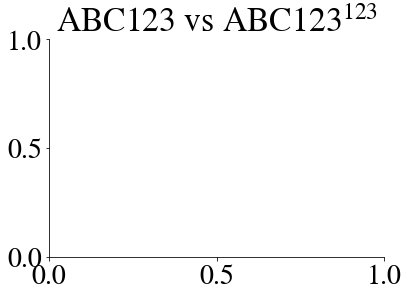

In [54]:
import matplotlib

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"
matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")


matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

palette = sns.color_palette("colorblind", 5)
sns.set_palette(palette)

In [14]:
##################
### Parameters ###
##################

# Data parameters
SEED = 1
# DATASET_NAME = "CountryCapital"
# DATASET_KWARGS_IDENTIFIABLE = dict(
#     max_contexts=450,
#     max_entities=90,
#     cap_per_type=True,
#     raw_country_capitals_path="data/CountryCapital/real-fake-historical-fictional-famousfictional-country-capital.csv",
# )
DATASET_NAME = "FriendEnemy"
# DATASET_KWARGS_IDENTIFIABLE = dict(
#     max_contexts=15,
#     max_entities=5,
#     cap_per_type=False,
#     raw_data_path="data/FriendEnemy/raw-friend-enemy.csv",
# )
DATASET_KWARGS_IDENTIFIABLE = dict(
    max_contexts=657,
    max_entities=73,
    cap_per_type=False,
    raw_data_path="data/FriendEnemy/raw-friend-enemy.csv",
    entity_selection_func_name="random_sample",
)
LOG_DATASETS = True

# Model parameters
# MODEL_ID = "EleutherAI/pythia-70m-deduped"
# LOAD_IN_8BIT = False
MODEL_ID = "EleutherAI/pythia-6.9b-deduped"
LOAD_IN_8BIT = True
BATCH_SZ = 16

# Evaluation switches
COMPUTE_CMI = True
COMPUTE_KL = True
COMPUTE_GOOD_BAD = True
COMPUTE_GOOD_BAD_ABS = True
COMPUTE_GOOD_BAD_P_GOOD_ONLY = True

# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["friend-enemy", "analysis"]

In [15]:
# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [16]:
# Paths
# Construct dataset and data ids
# dataset = getattr(sys.modules[__name__], DATASET_NAME)(**DATASET_KWARGS_IDENTIFIABLE)
data_id = f"{DATASET_NAME}"
data_id += (
    f"-mc{DATASET_KWARGS_IDENTIFIABLE['max_contexts']}"
    if "max_contexts" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["max_contexts"] is not None
    else ""
)
data_id += (
    f"-me{DATASET_KWARGS_IDENTIFIABLE['max_entities']}"
    if "max_entities" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["max_entities"] is not None
    else ""
)
data_id += (
    "-cappertype"
    if "cap_per_type" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["cap_per_type"]
    else ""
)
data_id += (
    "-ablate"
    if "ablate_out_relevant_contexts" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["ablate_out_relevant_contexts"]
    else ""
)
data_id += (
    f"-ES_{DATASET_KWARGS_IDENTIFIABLE['entity_selection_func_name']}"
    if "entity_selection_func_name" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["entity_selection_func_name"] is not None
    else ""
)

data_dir = os.path.join("data", DATASET_NAME, data_id, f"{SEED}")
input_dir = os.path.join(data_dir, "inputs")
entities_path = os.path.join(input_dir, "entities.json")
contexts_path = os.path.join(input_dir, "contexts.json")
queries_path = os.path.join(input_dir, "queries.json")
val_data_path = os.path.join(input_dir, "val.csv")
DATASET_KWARGS_IDENTIFIABLE = {
    **DATASET_KWARGS_IDENTIFIABLE,
    **dict(
        entities_path=entities_path,
        contexts_path=contexts_path,
        queries_path=queries_path,
    ),
}

# Construct model id
model_id = f"{MODEL_ID}"
model_id += "-8bit" if LOAD_IN_8BIT else ""
model_dir = os.path.join(data_dir, "models", model_id)

# Results path
results_dir = os.path.join(model_dir, "results")
val_results_path = os.path.join(results_dir, "val.csv")

print(f"Data dir: {data_dir}")
print(f"Model dir: {model_dir}")

Data dir: data/FriendEnemy/FriendEnemy-mc657-me73-ES_random_sample/1
Model dir: data/FriendEnemy/FriendEnemy-mc657-me73-ES_random_sample/1/models/EleutherAI/pythia-6.9b-deduped-8bit


In [17]:
# Analysis dir
analysis_dir = os.path.join(data_dir, "analysis")
print(f"Analysis dir: {analysis_dir}")

Analysis dir: data/FriendEnemy/FriendEnemy-mc657-me73-ES_random_sample/1/analysis


In [18]:
os.makedirs(input_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(analysis_dir, exist_ok=True)
# dataset = getattr(sys.modules[__name__], DATASET_NAME)(**DATASET_KWARGS_IDENTIFIABLE)

In [19]:
# GPU stuff
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
# wandb stuff
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), "analysis.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    mode="online",
)
print(dict(wandb.config))

/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


{'SEED': 1, 'DATASET_NAME': 'FriendEnemy', 'DATASET_KWARGS_IDENTIFIABLE': {'max_contexts': 657, 'max_entities': 73, 'cap_per_type': False, 'raw_data_path': 'data/FriendEnemy/raw-friend-enemy.csv', 'entity_selection_func_name': 'random_sample', 'entities_path': 'data/FriendEnemy/FriendEnemy-mc657-me73-ES_random_sample/1/inputs/entities.json', 'contexts_path': 'data/FriendEnemy/FriendEnemy-mc657-me73-ES_random_sample/1/inputs/contexts.json', 'queries_path': 'data/FriendEnemy/FriendEnemy-mc657-me73-ES_random_sample/1/inputs/queries.json'}, 'LOG_DATASETS': True, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': True, 'BATCH_SZ': 16, 'COMPUTE_CMI': True, 'COMPUTE_KL': True, 'COMPUTE_GOOD_BAD': True, 'COMPUTE_GOOD_BAD_ABS': True, 'COMPUTE_GOOD_BAD_P_GOOD_ONLY': True, 'PROJECT_NAME': 'context-vs-bias', 'GROUP_NAME': None, 'TAGS': ['friend-enemy', 'analysis']}


### Load Data

In [21]:
from ast import literal_eval

val_df_contexts_per_qe = pd.read_csv(
    val_results_path, index_col=0, converters={"contexts": literal_eval}
)

In [22]:
# After loading/preprocessing your dataset, log it as an artifact to W&B
if LOG_DATASETS:
    print(f"Logging datasets to w&b run {wandb.run}.")
    artifact = wandb.Artifact(name=data_id, type="dataset")
    artifact.add_dir(local_path=input_dir)
    run.log_artifact(artifact)

wandb: Adding directory to artifact (./data/FriendEnemy/FriendEnemy-mc657-me73-ES_random_sample/1/inputs)... Done. 0.1s


Logging datasets to w&b run <wandb.sdk.wandb_run.Run object at 0x2afb88fbe290>.


### Analyze Data

In [23]:
val_df_contexts_per_qe.head()

,q_id,query_form,entity,answer,contexts,susceptibility_score,persuasion_scores,full_query_example
0,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"('USA', 'Al-Qaeda')",NaN,"[Joe Frazier likes Muhammad Ali.\n, Shrek hate...",0.080530,"[0.5405588, 0.7602446, -0.24549723, -0.0245199...",Joe Frazier likes Muhammad Ali.\nQ: Are USA an...
1,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"('Han Solo', 'Chewbacca')",NaN,"[Joe Frazier likes Muhammad Ali.\n, Shrek hate...",0.051068,"[0.33029962, 0.3022604, -0.09144688, -0.519767...",Joe Frazier likes Muhammad Ali.\nQ: Are Han So...
2,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"('Optimus Prime', 'Megatron')",NaN,"[Joe Frazier likes Muhammad Ali.\n, Shrek hate...",0.056026,"[0.47376013, 0.3850994, -0.06115198, -0.450933...",Joe Frazier likes Muhammad Ali.\nQ: Are Optimu...
3,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"('Larry Page', 'Sergei Brin')",NaN,"[Joe Frazier likes Muhammad Ali.\n, Shrek hate...",0.074861,"[0.3107729, 0.4048748, 0.20202398, -0.4392166,...",Joe Frazier likes Muhammad Ali.\nQ: Are Larry ...
4,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"('Frodo Baggins', 'Samwise Gamgee')",NaN,"[Joe Frazier likes Muhammad Ali.\n, Shrek hate...",0.061453,"[0.41401458, 1.0463665, 0.34870815, -0.4596245...",Joe Frazier likes Muhammad Ali.\nQ: Are Frodo ...


In [24]:
val_df_contexts_per_qe["entity"] = val_df_contexts_per_qe["entity"].apply(eval)
val_df_contexts_per_qe["entity"].value_counts()

(USA, Al-Qaeda)                      5
(Superman, Lex Luthor)               5
(Woody, Buzz Lightyear)              5
(Spiderman, Norman Osborne)          5
(Winston Churchill, Adolf Hitler)    5
                                    ..
(Airbus, Boeing)                     5
(C.S. Lewis, J.R.R. Tolkien)         5
(Mark Twain, Nikola Tesla)           5
(Sherlock Holmes, John Watson)       5
(McDonalds, Burger King)             5
Name: entity, Length: 73, dtype: int64

In [25]:
val_df_contexts_per_qe.iloc[0]["contexts"][:10]

['Joe Frazier likes Muhammad Ali.\n',
 'Shrek hates Donkey.\n',
 'Bilbo Baggins adores Sauron.\n',
 'USA loves Soviet Union.\n',
 'Borussia Dortmund meets FC Bayern Munich.\n',
 'C.S. Lewis meets J.R.R. Tolkien.\n',
 'Georges Braque adores Pablo Picasso.\n',
 'Harry Potter hates Hermione Granger.\n',
 'Sheriff of Nottingham adores Robin Hood.\n',
 'Winston Churchill detests Adolf Hitler.\n']

In [26]:
friend_enemy_data = pd.read_csv(
    DATASET_KWARGS_IDENTIFIABLE["raw_data_path"],
    # os.path.join("data", DATASET_NAME, "real-fake-country-capital.csv"),
    # index_col=0,
)
friend_enemy_data["entity"] = list(
    zip(friend_enemy_data["ent1"], friend_enemy_data["ent2"])
)
friend_enemy_data

,ent1,ent2,label,type,entity
0,Sherlock Holmes,James Moriarty,enemy,movie,"(Sherlock Holmes, James Moriarty)"
1,Obi Wan Kenobi,Darth Maul,enemy,movie,"(Obi Wan Kenobi, Darth Maul)"
2,Harry Potter,Lord Voldemort,enemy,movie,"(Harry Potter, Lord Voldemort)"
3,Harry Potter,Draco Malfoy,enemy,movie,"(Harry Potter, Draco Malfoy)"
4,Spiderman,Norman Osborne,enemy,movie,"(Spiderman, Norman Osborne)"
...,...,...,...,...,...
68,Bill Gates,Paul Allen,friend,business,"(Bill Gates, Paul Allen)"
69,Larry Page,Sergei Brin,friend,business,"(Larry Page, Sergei Brin)"
70,Mike Wazowski,James P. Sullivan,friend,movie,"(Mike Wazowski, James P. Sullivan)"
71,Sherlock Holmes,John Watson,friend,movie,"(Sherlock Holmes, John Watson)"


In [27]:
val_df_contexts_per_qe

,q_id,query_form,entity,answer,contexts,susceptibility_score,persuasion_scores,full_query_example
0,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(USA, Al-Qaeda)",NaN,"[Joe Frazier likes Muhammad Ali.\n, Shrek hate...",0.080530,"[0.5405588, 0.7602446, -0.24549723, -0.0245199...",Joe Frazier likes Muhammad Ali.\nQ: Are USA an...
1,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Han Solo, Chewbacca)",NaN,"[Joe Frazier likes Muhammad Ali.\n, Shrek hate...",0.051068,"[0.33029962, 0.3022604, -0.09144688, -0.519767...",Joe Frazier likes Muhammad Ali.\nQ: Are Han So...
2,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Optimus Prime, Megatron)",NaN,"[Joe Frazier likes Muhammad Ali.\n, Shrek hate...",0.056026,"[0.47376013, 0.3850994, -0.06115198, -0.450933...",Joe Frazier likes Muhammad Ali.\nQ: Are Optimu...
3,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Larry Page, Sergei Brin)",NaN,"[Joe Frazier likes Muhammad Ali.\n, Shrek hate...",0.074861,"[0.3107729, 0.4048748, 0.20202398, -0.4392166,...",Joe Frazier likes Muhammad Ali.\nQ: Are Larry ...
4,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Frodo Baggins, Samwise Gamgee)",NaN,"[Joe Frazier likes Muhammad Ali.\n, Shrek hate...",0.061453,"[0.41401458, 1.0463665, 0.34870815, -0.4596245...",Joe Frazier likes Muhammad Ali.\nQ: Are Frodo ...
...,...,...,...,...,...,...,...,...
360,friend-enemy,The relationship between {} and {} is,"(Shrek, Donkey)",NaN,"[Joe Frazier likes Muhammad Ali.\n, Shrek hate...",0.181566,"[0.15775013, 0.6210022, 0.3696432, 0.22057581,...",Joe Frazier likes Muhammad Ali.\nThe relations...
361,friend-enemy,The relationship between {} and {} is,"(Super Mario, Bowser)",NaN,"[Joe Frazier likes Muhammad Ali.\n, Shrek hate...",0.182811,"[0.21136904, 0.31816483, 0.28743505, 0.1986312...",Joe Frazier likes Muhammad Ali.\nThe relations...
362,friend-enemy,The relationship between {} and {} is,"(James Bond, Ernst Stavro Blofeld)",NaN,"[Joe Frazier likes Muhammad Ali.\n, Shrek hate...",0.202966,"[0.043773174, 0.22363901, 0.196774, 0.26838398...",Joe Frazier likes Muhammad Ali.\nThe relations...
363,friend-enemy,The relationship between {} and {} is,"(Green Bay Packers, Chicago Bears)",NaN,"[Joe Frazier likes Muhammad Ali.\n, Shrek hate...",0.106326,"[0.012602806, 0.21839571, 0.057354927, 0.09041...",Joe Frazier likes Muhammad Ali.\nThe relations...


In [28]:
val_df_per_qe = val_df_contexts_per_qe.merge(
    friend_enemy_data[["entity", "type", "label"]],
    # left_on=["ent1", "ent2"],
    # right_on=["ent1", "ent2"],
    how="left",
)[
    [
        "q_id",
        "query_form",
        "entity",
        "type",
        "susceptibility_score",
        "label",
    ]
]
val_df_per_qe

,q_id,query_form,entity,type,susceptibility_score,label
0,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(USA, Al-Qaeda)",politics,0.080530,enemy
1,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Han Solo, Chewbacca)",movie,0.051068,friend
2,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Optimus Prime, Megatron)",movie,0.056026,enemy
3,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Larry Page, Sergei Brin)",business,0.074861,friend
4,friend-enemy,Q: Are {} and {} friends or enemies?\nA:,"(Frodo Baggins, Samwise Gamgee)",movie,0.061453,friend
...,...,...,...,...,...,...
360,friend-enemy,The relationship between {} and {} is,"(Shrek, Donkey)",movie,0.181566,friend
361,friend-enemy,The relationship between {} and {} is,"(Super Mario, Bowser)",movie,0.182811,enemy
362,friend-enemy,The relationship between {} and {} is,"(James Bond, Ernst Stavro Blofeld)",movie,0.202966,enemy
363,friend-enemy,The relationship between {} and {} is,"(Green Bay Packers, Chicago Bears)",sports,0.106326,enemy


In [29]:
query_forms = val_df_per_qe["query_form"].unique()
print(query_forms)
for qf in query_forms:
    print(
        val_df_per_qe[val_df_per_qe["query_form"] == qf].sort_values(
            by="susceptibility_score"
        )
    )

['Q: Are {} and {} friends or enemies?\nA:'
 'Q: How friendly are {} and {}?\nA:'
 'Q: What is the relationship between {} and {}?\nA:' '{} and {} are'
 'The relationship between {} and {} is']
            q_id                                query_form  \
21  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
66  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
65  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
68  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
37  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
..           ...                                       ...   
62  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
7   friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
71  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
40  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   
49  friend-enemy  Q: Are {} and {} friends or enemies?\nA:   

                                entity      type  susceptibil

In [30]:
df_qf = val_df_per_qe[val_df_per_qe["query_form"] == query_forms[-1]].sort_values(
    by="susceptibility_score"
)

for e, s in list(zip(df_qf["entity"].tolist(), df_qf["susceptibility_score"].tolist())):
    print(e, s)

('Donald Trump', 'Hillary Clinton') 0.0905349693818255
('Real Madrid', 'FC Barcelona') 0.0947212592931008
('Borussia Dortmund', 'FC Bayern Munich') 0.09663547781908
('Donald Trump', 'Joe Biden') 0.0985230452953782
('Green Bay Packers', 'Chicago Bears') 0.1063258080605508
('Democrats', 'Republicans') 0.1066063302310076
('Sony', 'Nintendo') 0.1088326710298988
('USA', 'Al-Qaeda') 0.1139818621390492
('Kuomintang', 'Chinese Communist Party') 0.1167058838809318
('AC Milan', 'Inter Milan') 0.1193438616644742
('George Bush', 'Saddam Hussein') 0.1288688457452784
('Airbus', 'Boeing') 0.130446314140797
('Moby Dick', 'Captain Ahab') 0.1397760940559077
('Boston Red Sox', 'New York Yankees') 0.1473233826260379
('Gauls', 'Rome') 0.1551426628635983
('Steve Jobs', 'Bill Gates') 0.1561965217547793
('UPS', 'Fedex') 0.1578655058295002
('Torries', 'Labor Party') 0.1618809936215484
('Gandalf', 'Saruman') 0.1672252825958358
('Visa', 'Mastercard') 0.1672555144253289
('Bill Gates', 'Warren Buffett') 0.16932600

<AxesSubplot:xlabel='query_form', ylabel='susceptibility_score'>

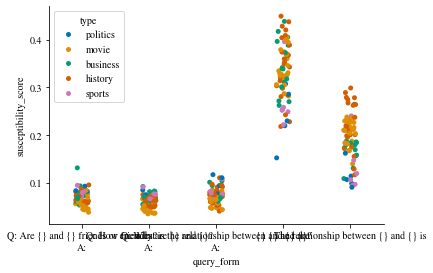

In [31]:
sns.stripplot(
    data=val_df_per_qe,
    x="query_form",
    y="susceptibility_score",
    hue="type",
    # hue="label",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)

<AxesSubplot:xlabel='query_form', ylabel='susceptibility_score'>

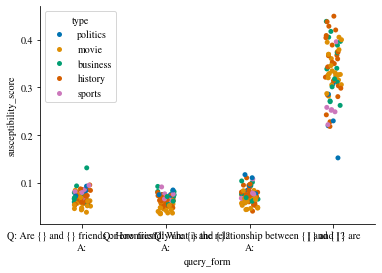

In [32]:
sns.stripplot(
    data=val_df_per_qe[val_df_per_qe["query_form"] != query_forms[-1]],
    x="query_form",
    y="susceptibility_score",
    hue="type",
    # hue="label",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)

In [137]:
val_df_per_qe["query_form"].unique()

array(['Q: Are {} and {} friends or enemies?\nA:',
       'Q: How friendly are {} and {}?\nA:',
       'Q: What is the relationship between {} and {}?\nA:',
       '{} and {} are', 'The relationship between {} and {} is'],
      dtype=object)

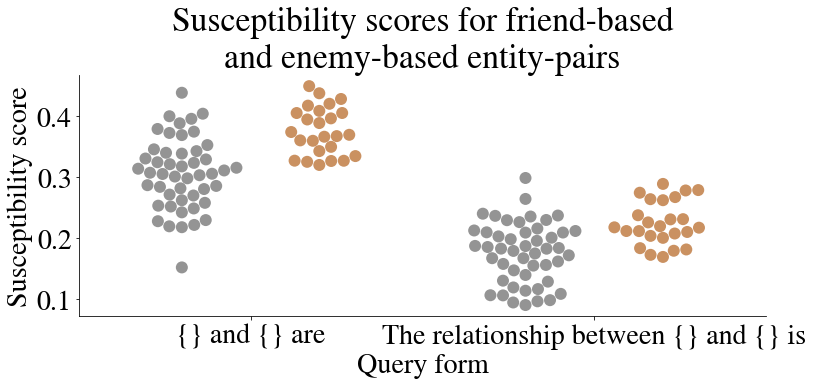

In [153]:
fig, ax = plt.subplots(figsize=(12, 6))
val_df_per_qe2 = val_df_per_qe[
    val_df_per_qe["query_form"].isin(
        [
            # "Q: What is the relationship between {} and {}?\nA:",
            "{} and {} are",
            "The relationship between {} and {} is",
        ]
    )
]
plot = sns.swarmplot(
    data=val_df_per_qe2,
    x="query_form",
    y="susceptibility_score",
    hue="label",
    size=12,
    ax=ax,
    # palette=sns.color_palette("colorblind")[6:],
    legend=None,
    dodge=True,
    palette=[colormap[e] for e in val_df_per_qe["label"].unique()],
)
ax.set_xlabel("Query form")
ax.set_ylabel("Susceptibility score")
ax.set_title("Susceptibility scores for friend-based\nand enemy-based entity-pairs")
plt.tight_layout()
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
plot_name = "plot_susscore_vs_queryform_friend_enemy"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

In [105]:
entities = val_df_per_qe["entity"].drop_duplicates().sample(n=20, random_state=1)
entities

19                (Thomas Edison, Henry Ford)
55                        (USA, Soviet Union)
10                  (Moby Dick, Captain Ahab)
69                      (Super Mario, Bowser)
54                (Real Madrid, FC Barcelona)
26                               (Cain, Abel)
40                (Marc Twain, Hellen Keller)
33             (Harry Potter, Ronald Weasley)
34           (Vincent van Gogh, Paul Gauguin)
60                   (Democrats, Republicans)
44              (John Lennon, Paul McCartney)
47                         (Coca Cola, Pepsi)
2                   (Optimus Prime, Megatron)
53                    (Woody, Buzz Lightyear)
27                   (Bill Gates, Paul Allen)
39          (Sherlock Holmes, James Moriarty)
15    (Netscape, Microsoft Internet Explorer)
43         (Mike Wazowski, James P. Sullivan)
35                               (Tom, Jerry)
67                    (AC Milan, Inter Milan)
Name: entity, dtype: object

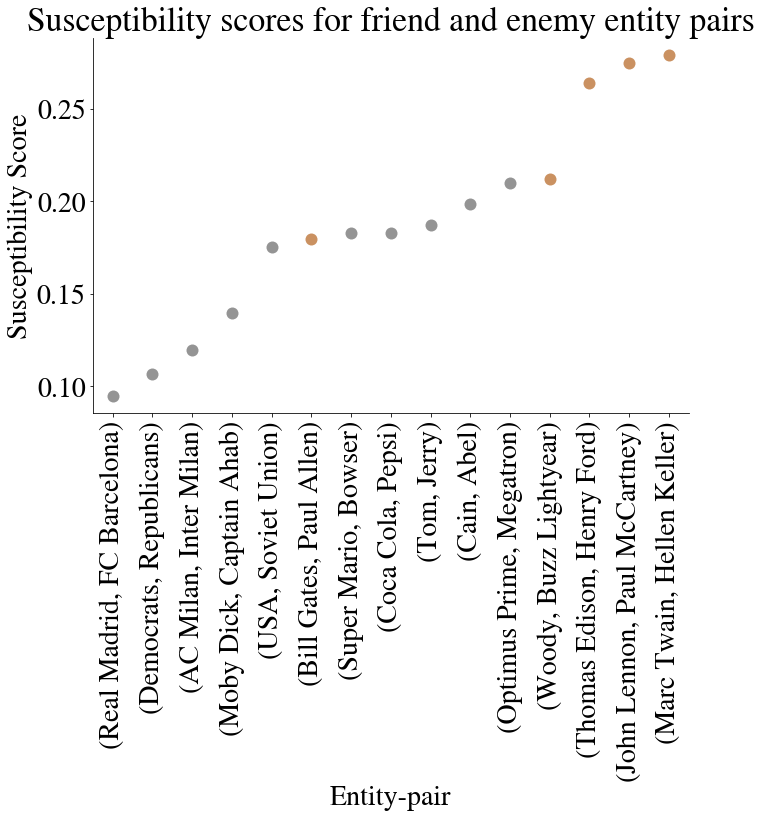

In [132]:
palette = sns.color_palette("colorblind")
REAL_COLOR = palette[5]
FAKE_COLOR = palette[-3]
colormap = {
    "friend": REAL_COLOR,
    "enemy": FAKE_COLOR,
}

fig, ax = plt.subplots(figsize=(10.5, 12))
val_df_per_qe_sample = val_df_per_qe[val_df_per_qe["entity"].isin(entities.tolist())]
df = val_df_per_qe_sample[
    val_df_per_qe_sample["query_form"] == "The relationship between {} and {} is"
].sort_values(
    "susceptibility_score",
)
# print(df)
# print(
#     df.sort_values(["query_form", "susceptibility_score"])[
#         ["entity", "type", "label", "susceptibility_score"]
#     ]
# )
df["entity"] = df["entity"].apply(lambda x: "(" + ", ".join(x) + ")")
df["entity_len"] = df["entity"].apply(len)
df = df[df["entity_len"] < 30]
sns.stripplot(
    df,
    x="entity",
    y="susceptibility_score",
    hue="label",
    size=12,
    legend=None,
    ax=ax,
    palette=[colormap[e] for e in val_df_per_qe["label"].unique()],
)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_title(qf)
ax.set_title("Susceptibility scores for friend and enemy entity pairs")
ax.set_xlabel("Entity-pair")
ax.set_ylabel("Susceptibility Score")
plt.tight_layout()
plot_name = "plot_susscore_vs_friend_enemy"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

In [102]:
print(val_df_per_qe_sample["query_form"].unique())

['Q: Are {} and {} friends or enemies?\nA:'
 'Q: How friendly are {} and {}?\nA:'
 'Q: What is the relationship between {} and {}?\nA:' '{} and {} are'
 'The relationship between {} and {} is']


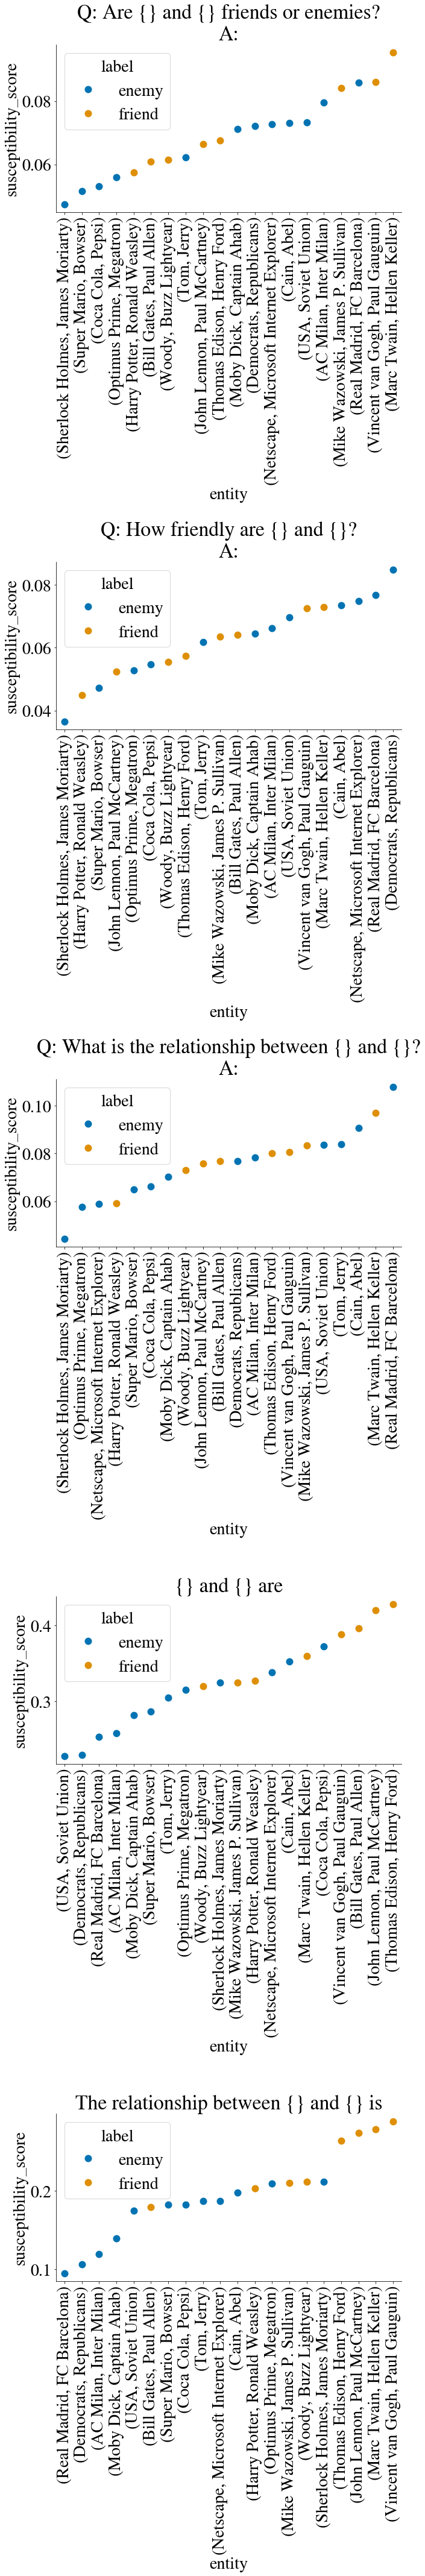

In [107]:
nrows = len(val_df_per_qe["query_form"].unique())
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10, 12 * nrows))
val_df_per_qe_sample = val_df_per_qe[val_df_per_qe["entity"].isin(entities.tolist())]
for i, qf in enumerate(val_df_per_qe_sample["query_form"].unique()):
    ax = axes[i]
    df = val_df_per_qe_sample[val_df_per_qe_sample["query_form"] == qf].sort_values(
        "susceptibility_score",
    )
    # print(df)
    # print(
    #     df.sort_values(["query_form", "susceptibility_score"])[
    #         ["entity", "type", "label", "susceptibility_score"]
    #     ]
    # )
    df["entity"] = df["entity"].apply(lambda x: "(" + ", ".join(x) + ")")
    sns.stripplot(df, x="entity", y="susceptibility_score", hue="label", size=12, ax=ax)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set_title(qf)
    plt.tight_layout()
    print("\n\n\n")

In [95]:
str(("asdf", "sdf"))

"('asdf', 'sdf')"

In [34]:
val_df_per_qe["query_form"].unique()

array(['Q: Are {} and {} friends or enemies?\nA:',
       'Q: How friendly are {} and {}?\nA:',
       'Q: What is the relationship between {} and {}?\nA:',
       '{} and {} are', 'The relationship between {} and {} is'],
      dtype=object)

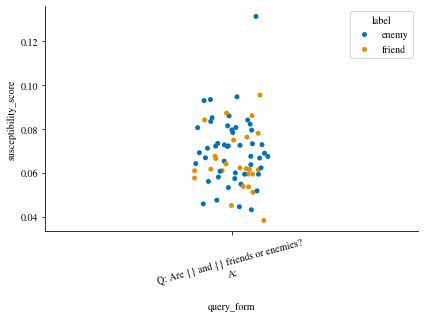

In [35]:
fig, ax = plt.subplots()
plot = sns.stripplot(
    data=val_df_per_qe[
        val_df_per_qe["query_form"] == "Q: Are {} and {} friends or enemies?\nA:"
    ],
    x="query_form",
    y="susceptibility_score",
    hue="label",
    ax=ax,
)
plt.tight_layout()
for tick in ax.get_xticklabels():
    tick.set_rotation(15)
plot_name = "plot_susscore_vs_queryform_friend_enemy"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

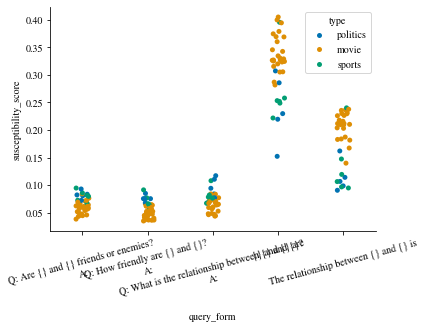

In [36]:
fig, ax = plt.subplots()
plot = sns.stripplot(
    data=val_df_per_qe[
        val_df_per_qe["type"].isin(
            [
                "sports",
                "politics",
                "movie",
            ]
        )
    ],
    x="query_form",
    y="susceptibility_score",
    hue="type",
    ax=ax,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)
plt.tight_layout()
for tick in ax.get_xticklabels():
    tick.set_rotation(15)
plot_name = "plot_susscore_vs_queryform_type"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

In [ ]:
fig

In [ ]:
wandb.finish()